<a href="http://lnls.cnpem.br/"><img src="http://fig.if.usp.br/~biofisic/images/logo_lnls.jpg" style="width:90px; float: left;"></a><h1> Cross-check Analysis for both Rotating Coils SI </h1>

----

In [159]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to turn on / off the source code"></form>''')

In [1]:
#Import Library
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
plt.style.use('bmh')
import time
import datetime
import sys
import pandas as pd
from PySide import QtGui
% matplotlib inline

In [2]:
class Cross_check(object):
    def __init__(self):
        self.file = np.array([])
        self.Raw = np.array([])
        self.Current = np.array([])
        self.Multipoles = np.array([])
        self.Curves = np.array([])
        self.multipoleseries = pd.Series()
        self.curveseries = pd.Series()
        self.multipoledf = None
        self.curvesdf = None
        
    def Load_Files(self):
        """
        Load the input files.
        """
        app=QtGui.QApplication.instance()
        if not app:
            app = QtGui.QApplication(sys.argv)
        file_path = QtGui.QFileDialog.getOpenFileNames()
        self.files = self.sortList(file_path[0])
        self.Load_Data()

    def sortList(self,list):            #Função pega todos os dados e organiza-os por data de entrada, impossibilitando as informções aleatórias.
        index = np.array([])
        for i in range(len(list)):
            index = np.append(index, time.mktime(datetime.datetime.strptime(list[i][list[i].find('.dat')-13:list[i].find('.dat')], '%y%m%d_%H%M%S').timetuple()))
        index = index.argsort()

        File_List = np.array([])
        for i in range(len(list)):
            File_List = np.append(File_List,list[index[i]])

        return File_List

    def Load_Data(self):                #Função pega todos os dados da bobina e organiza-os.
        #try:
        self.Data = np.array([])
        n = len(self.files)
        for i in range(n):
            self.Data = np.append(self.Data, Cross_check())
            self.Data[i].file = self.files[i] 
            arq = open(self.Data[i].file)
            self.Data[i].Raw = np.array(arq.read().splitlines())

            #Read Currents
            index_current = np.where(np.char.find(self.Data[i].Raw,'main_coil_current_avg') > -1)[0][0]
            current = float(self.Data[i].Raw[index_current].split('\t')[1])
            self.Data[i].Current = current

            # Read Multipoles
            index_multipoles = np.where(np.char.find(self.Data[i].Raw,'Reading Data') > -1)[0][0] + 3
            multipoles = self.Data[i].Raw[index_multipoles:index_multipoles+15]
            for value in multipoles:
                self.Data[i].Multipoles = np.append(self.Data[i].Multipoles,value.split('\t'))
            self.Data[i].Multipoles = self.Data[i].Multipoles.reshape(15,13).astype(np.float64)

            # Read Curves
            index_curves = np.where(np.char.find(self.Data[i].Raw,'Raw Data Stored') > -1)[0][0] + 3 
            curves = self.Data[i].Raw[index_curves:]
            for value in curves:
                self.Data[i].Curves = np.append(self.Data[i].Curves,value[:-1].split('\t'))
            self.Data[i].Curves = self.Data[i].Curves.reshape(int(len(curves)),int(len(self.Data[i].Curves)/len(curves))).astype(np.float64) * 1e-12

        #Read Columns names
        index_multipoles = np.where(np.char.find(self.Data[0].Raw,'Reading Data') > -1)[0][0] + 2
        self.Columns = np.array(self.Data[0].Raw[index_multipoles].split('\t'))
        self.makeTable()
        #except:
         #     print('Fail')
                
    def makeTable(self):        
        for i in range(len(self.Data)):
            self.Data[i].multipoleseries = self.Data[i].multipoleseries.append(pd.Series([self.Data[i].Multipoles],index=[self.Data[i].Current]))
            self.Data[i].curveseries = self.Data[i].curveseries.append(pd.Series([self.Data[i].Curves],index=[self.Data[i].Current]))
         
            self.Data[i].multipoledf = pd.DataFrame(self.Data[i].multipoleseries.iloc[0], 
                                                    columns=self.Columns,
                                                    index=np.char.mod('%d',np.linspace(1, 15, 15)))
            
            _npoints = self.Data[i].curveseries.iloc[0].shape[0]
            _ncurves = self.Data[i].curveseries.iloc[0].shape[1]
            
            self.Data[i].curvesdf = pd.DataFrame(self.Data[i].curveseries.iloc[0],
                                                 index = np.char.mod('%d',np.linspace(1, _npoints, _npoints)),
                                                 columns = np.char.mod('%d',np.linspace(1, _ncurves, _ncurves)))

a = Cross_check()

### _Data Manipulation_

#### Parameters Dataset
> 
- Main Current: 156 A; 
- SIMA-Q: Q20-003 


In [164]:
dataset = pd.DataFrame([
    ['330356', '9', '0', '0.01296'],
    ['336391', '9', '0', '0.0130']],
    columns=['pulse_start_collect','n_turns_main_coil',
            'main_coil_internal_radius(m)','main_coil_external_radius(m)'],
    index=['SBG-1','SBG-2']
)
dataset

,pulse_start_collect,n_turns_main_coil,main_coil_internal_radius(m),main_coil_external_radius(m)
SBG-1,330356,9,0,0.01296
SBG-2,336391,9,0,0.0130


In [165]:
a.Load_Files()
for i in range(0,len(a.files)):
    a.Data[i].multipoledf.index = a.Data[i].multipoledf['n']
    
Ln2_mean = np.array([])
Ln3_mean = np.array([])    #Sextupole Normal
Ls3_mean = np.array([])    #Sextupole Skew
roll_mean = np.array([])
for i in range(len(a.files)):
    Ln2_mean = np.append(Ln2_mean, a.Data[i].multipoledf['avg_L.Nn(T/m^n-2)'][2])
    Ln3_mean = np.append(Ln3_mean, a.Data[i].multipoledf['avg_L.Nn(T/m^n-2)'][3])
    roll_mean = np.append(roll_mean, a.Data[i].multipoledf['std_angle(rad)  '][2])
    Ls3_mean = np.append(Ls3_mean, a.Data[i].multipoledf['avg_L.Sn(T/m^n-2)'][3])

In [4]:
_dict_0 ={         #SBG-1 at 0°
    'Média L.N(2)':Ln2_mean.mean(),
    'Média L.N(3)':Ln3_mean.mean(),
    'Média L.S(3)':Ls3_mean.mean(),
    'Média angulo':roll_mean.mean()
}

In [6]:
_dict_1 ={         #SBG-2 at 0°
    'Média L.N(2)':Ln2_mean.mean(),
    'Média L.N(3)':Ln3_mean.mean(),
    'Média L.S(3)':Ls3_mean.mean(),
    'Média angulo':roll_mean.mean()
}

In [166]:
_dict_2 ={         #SBG-1 at 180°
    'Média L.N(2)':Ln2_mean.mean(),
    'Média L.N(3)':Ln3_mean.mean(),
    'Média L.S(3)':Ls3_mean.mean(),
    'Média angulo':roll_mean.mean()
}

In [10]:
_dict_3 ={         #SBG-2 at 180°
    'Média L.N(2)':Ln2_mean.mean(),
    'Média L.N(3)':Ln3_mean.mean(),
    'Média L.S(3)':Ls3_mean.mean(),
    'Média angulo':roll_mean.mean()
}

### Tracing the mean values for SGB-1 and SGB-2 at 0° in Y axis

In [20]:
serie0 = pd.Series(_dict_0)  #SBG-1
serie1 = pd.Series(_dict_1)  #SBG-2
df = pd.DataFrame(serie0)
df['SBG-2 at 0°'] = serie1
df.columns = ['SBG-1 at 0°', 'SBG-2 at 0°']
df

,SBG-1 at 0°,SBG-2 at 0°
Média L.N(2),-9.091266,-9.107903
Média L.N(3),-0.004036,-0.054529
Média L.S(3),0.020295,0.005835
Média angulo,0.000011,0.000009


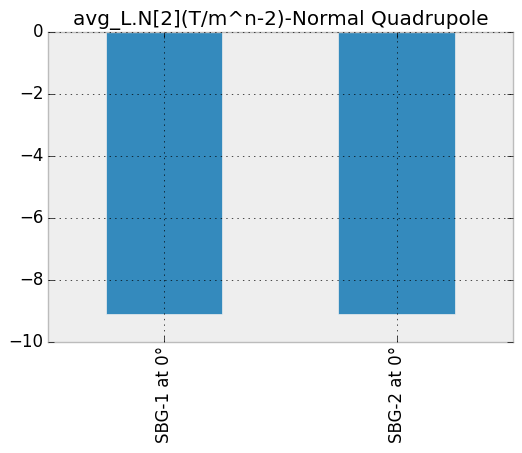

In [157]:
df.iloc[0].plot(kind='bar', title='avg_L.N[2](T/m^n-2)-Normal Quadrupole', fontsize=12)

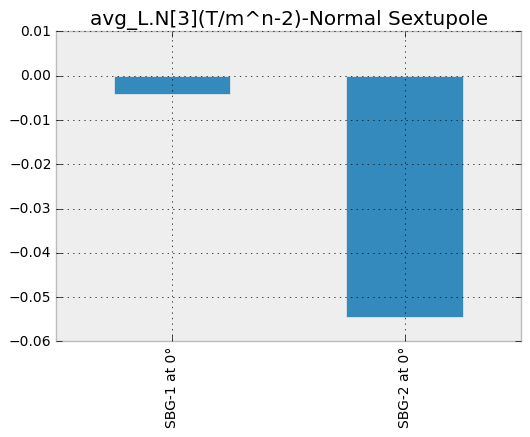

In [23]:
df.iloc[1].plot(kind='bar', title='avg_L.N[3](T/m^n-2)-Normal Sextupole')

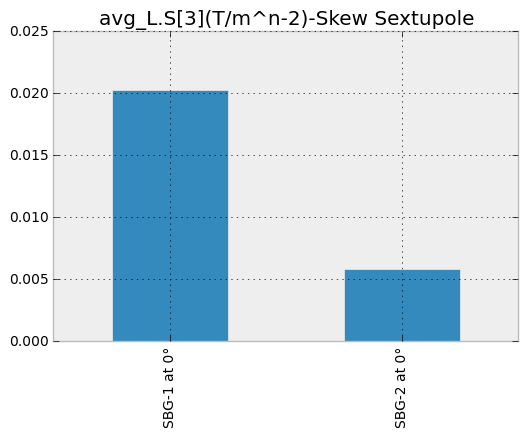

In [24]:
df.iloc[2].plot(kind='bar', title='avg_L.S[3](T/m^n-2)-Skew Sextupole')

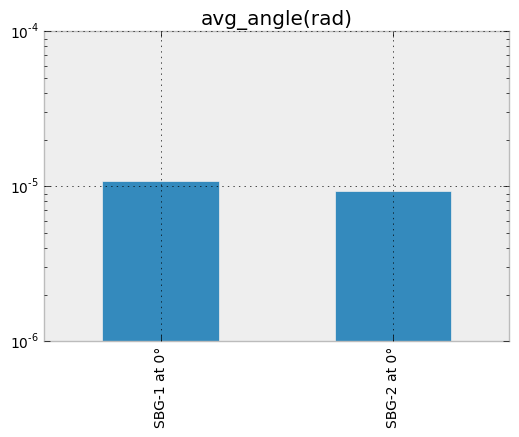

In [25]:
df.iloc[3].plot(kind='bar', title='avg_angle(rad)', logy='True')

### Tracing the mean values for SGB-1 and SGB-2 at 180° in Y axis

In [47]:
serie2 = pd.Series(_dict_2)  #SBG-1 - 180°
serie3 = pd.Series(_dict_3)  #SBG-2 - 180°
df2 = pd.DataFrame(serie2)
df2['SBG-2 at 180°'] = serie3
df2.columns = ['SBG-1 at 180°', 'SBG-2 at 180°']
df2

,SBG-1 at 180°,SBG-2 at 180°
Média L.N(2),9.092613,9.108991
Média L.N(3),0.114767,0.150284
Média L.S(3),-0.028141,0.006612
Média angulo,0.000010,0.000008


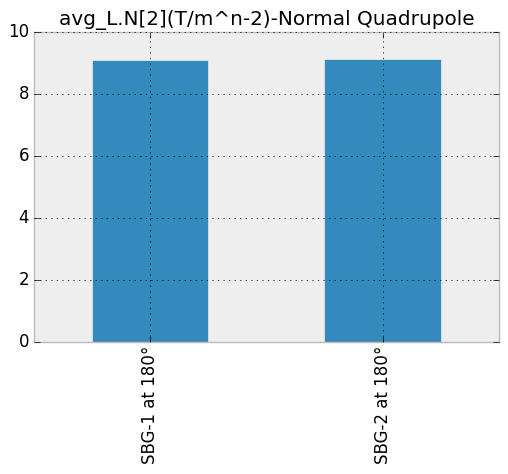

In [156]:
df2.iloc[0].plot(kind='bar', title='avg_L.N[2](T/m^n-2)-Normal Quadrupole', fontsize=12)

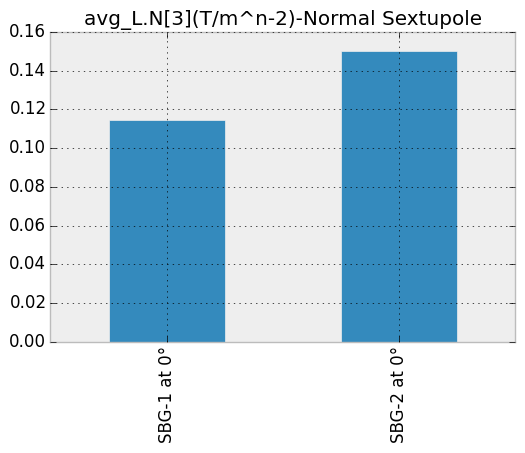

In [33]:
df2.iloc[1].plot(kind='bar', title='avg_L.N[3](T/m^n-2)-Normal Sextupole', fontsize=12)

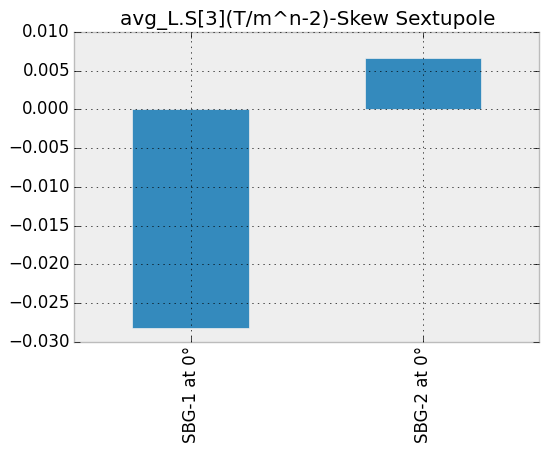

In [34]:
df2.iloc[2].plot(kind='bar', title='avg_L.S[3](T/m^n-2)-Skew Sextupole', fontsize=12)

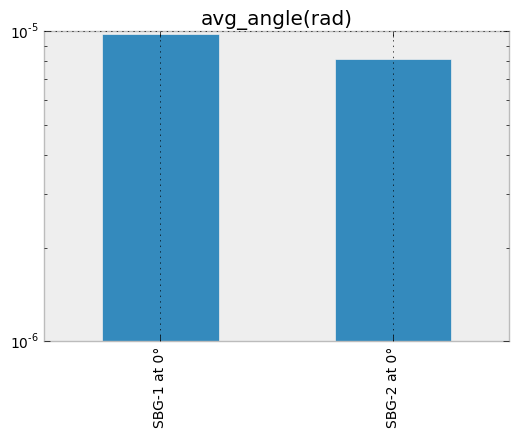

In [35]:
df2.iloc[3].plot(kind='bar', title='avg_angle(rad)', logy='True')

## Same coil in 0° and 180°

### SBG-1

In [161]:
#df

In [160]:
#df2

In [65]:
#sbg_1_SN = np.array([df['SBG-1 at 0°'].iloc[1], df2['SBG-1 at 180°'].iloc[1]])

In [95]:
df3 = pd.DataFrame([
            [df['SBG-1 at 0°'].iloc[0], df2['SBG-1 at 180°'].iloc[0]],
            [df['SBG-1 at 0°'].iloc[1], df2['SBG-1 at 180°'].iloc[1]],
            [df['SBG-1 at 0°'].iloc[2], df2['SBG-1 at 180°'].iloc[2]],
            [df['SBG-1 at 0°'].iloc[3], df2['SBG-1 at 180°'].iloc[3]]
            ],columns=['0°','180°'], index=['avg_L.N(2)','avg_L.N(3)', 'avg_L.S(3)', 'avg_ang(rad)'])
df3

,0°,180°
avg_L.N(2),-9.091266,9.092613
avg_L.N(3),-0.004036,0.114767
avg_L.S(3),0.020295,-0.028141
avg_ang(rad),0.000011,0.000010


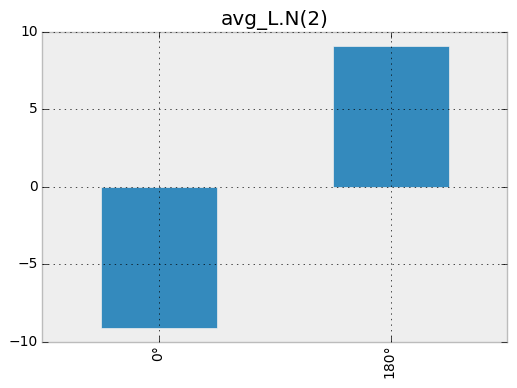

In [96]:
df3.iloc[0].plot(kind='bar', title='avg_L.N(2)')

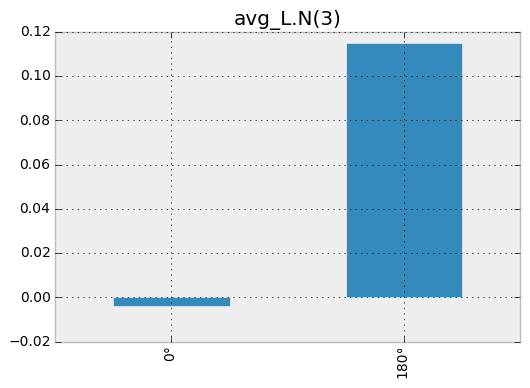

In [97]:
df3.iloc[1].plot(kind='bar', title='avg_L.N(3)')

In [85]:
#fig, ax = plt.subplots()
#ax.bar(np.arange(2), df3.iloc[0].values, 0.35)
#ax.set_xticks(np.arange(2) + 0.35 / 2)
#ax.set_xticklabels(('0º', '180°'))
#plt.show()

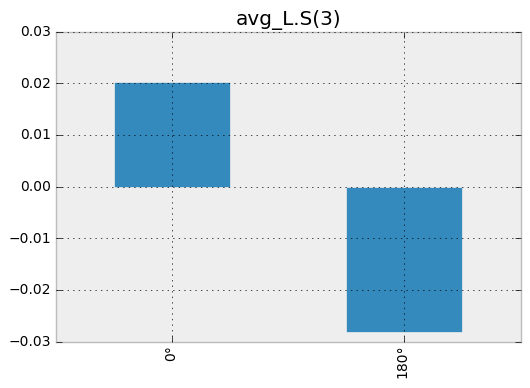

In [98]:
df3.iloc[2].plot(kind='bar', title='avg_L.S(3)')

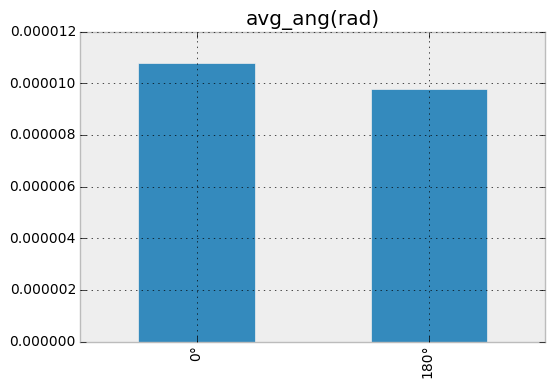

In [99]:
df3.iloc[3].plot(kind='bar', title='avg_ang(rad)')

In [93]:
df2['SBG-1 at 180°'].iloc[0]

9.0926134000000012

### SBG-2

In [102]:
df4 = pd.DataFrame([
            [df['SBG-2 at 0°'].iloc[0], df2['SBG-2 at 180°'].iloc[0]],
            [df['SBG-2 at 0°'].iloc[1], df2['SBG-2 at 180°'].iloc[1]],
            [df['SBG-2 at 0°'].iloc[2], df2['SBG-2 at 180°'].iloc[2]],
            [df['SBG-2 at 0°'].iloc[3], df2['SBG-2 at 180°'].iloc[3]]
            ],columns=['0°','180°'], index=['avg_L.N(2)','avg_L.N(3)', 'avg_L.S(3)', 'avg_ang(rad)'])
df4

,0°,180°
avg_L.N(2),-9.107903,9.108991
avg_L.N(3),-0.054529,0.150284
avg_L.S(3),0.005835,0.006612
avg_ang(rad),0.000009,0.000008


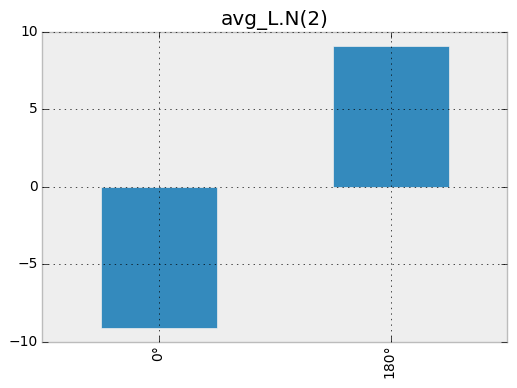

In [103]:
df4.iloc[0].plot(kind='bar', title='avg_L.N(2)')

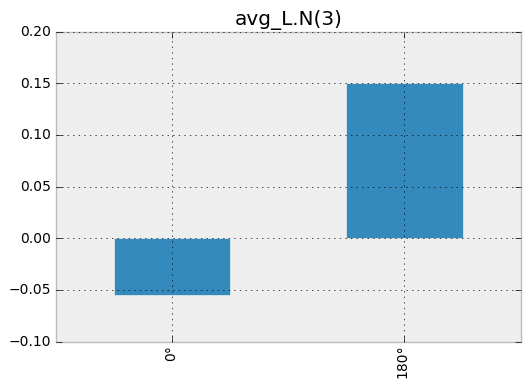

In [104]:
df4.iloc[1].plot(kind='bar', title='avg_L.N(3)')

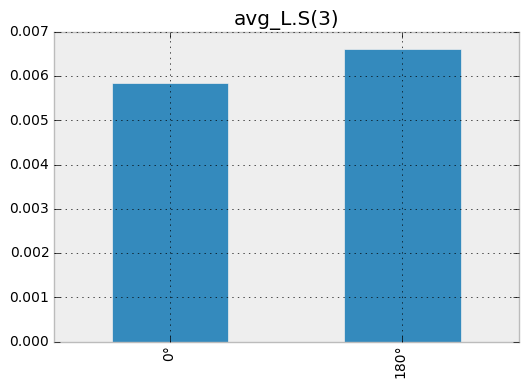

In [106]:
df4.iloc[2].plot(kind='bar', title='avg_L.S(3)')

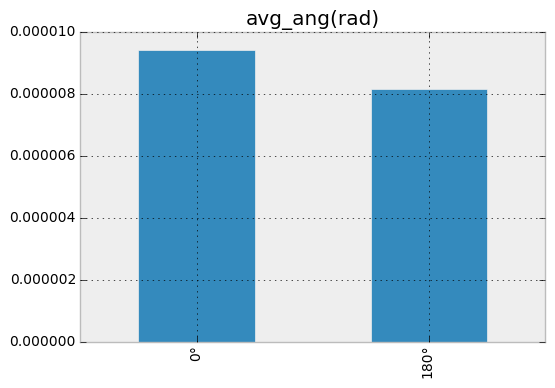

In [107]:
df4.iloc[3].plot(kind='bar', title='avg_ang(rad)')

In [142]:
from IPython.display import Image

## Comparison between SBG-1 and SBG-2 at 0° - Residual Normalized Normal Integrated Field
 
    -SBG-1, Encoder = 330356
    -SBG-2, Encoder = 336391


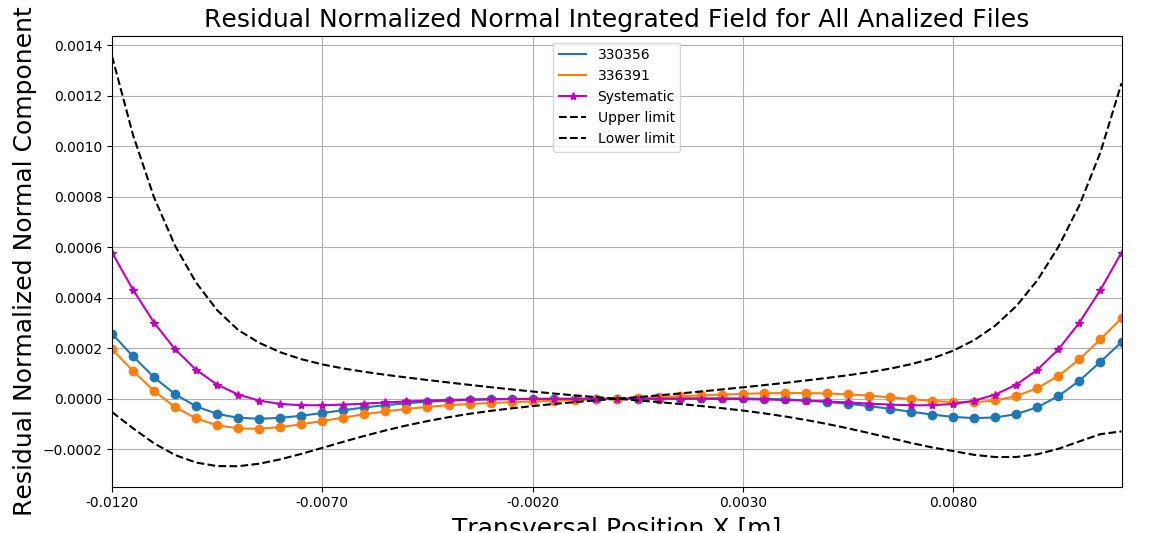

In [155]:
Image('D:/ARQ/Lucas/Comparison between storage ring coils/Comp_SBG1-SBG2_Normal_0°.png')#, width=800, height=800)

### Comparison between SBG-1 and SBG-2 at 180° - Residual Normalized Normal Integrated Field
 
    -SBG-1, Encoder = 330356
    -SBG-2, Encoder = 336391

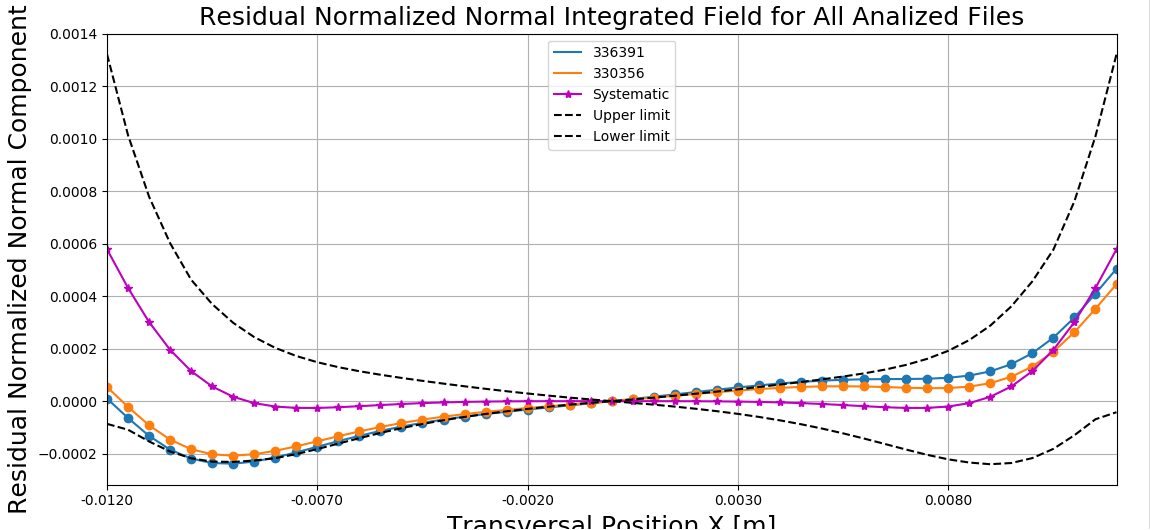

In [144]:
Image('D:/ARQ/Lucas/Comparison between storage ring coils/Comp_SBG1-SBG2_Normal_180°.png')

### Comparison between SBG-1 and SBG-2 at 0° - Residual Normalized Skew Integrated Field
 
    -SBG-1, Encoder = 330356
    -SBG-2, Encoder = 336391

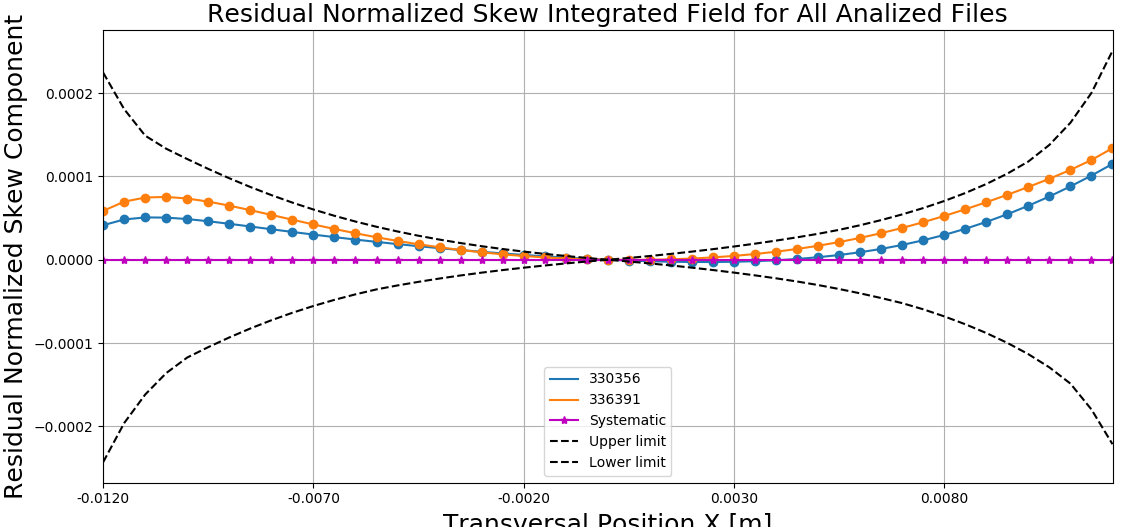

In [154]:
Image('D:/ARQ/Lucas/Comparison between storage ring coils/Comp_SBG1-SBG2_Skew_0°.png')

### Comparison between SBG-1 and SBG-2 at 180° - Residual Normalized Skew Integrated Field
 
    -SBG-1, Encoder = 330356
    -SBG-2, Encoder = 336391

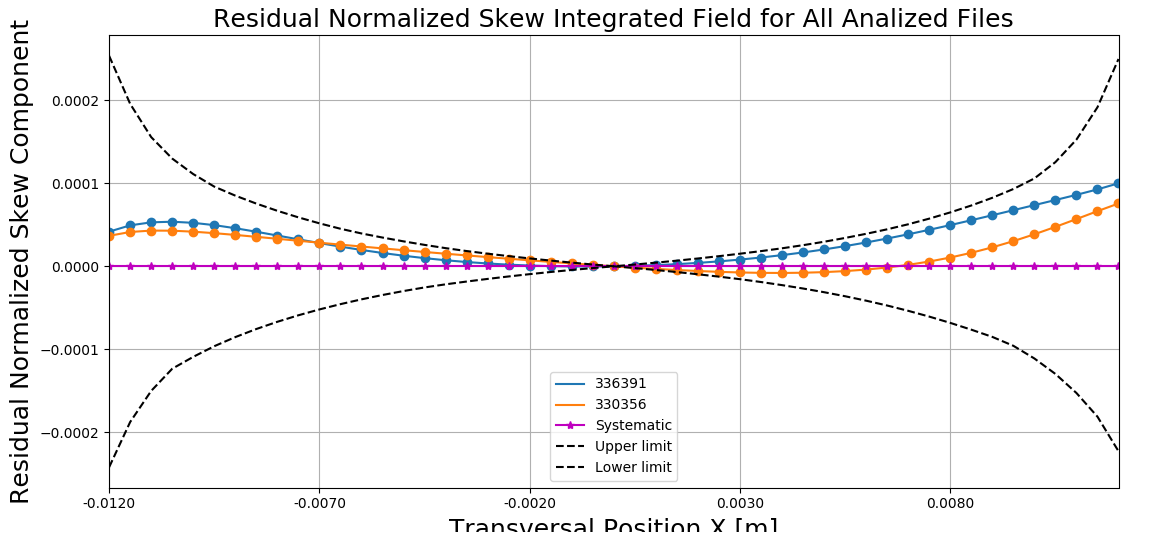

In [158]:
Image('D:/ARQ/Lucas/Comparison between storage ring coils/Comp_SBG1-SBG2_Skew_180°.png')